# Assignment 4

Cristian Piacente 866020 \
Advanced Machine Learning course \
Master's degree in Computer Science @ University of Milan - Bicocca \
A.Y. 2024-25

The task is next character prediction in a text. Starting from the provided skeleton of the code:
- properly divide the sequences into training, validation and test. Eventually use an external text for the test to assess the generalization ability
- evaluate the trained model in terms of prediction accuracy
- tune the chunk length to obtain the best performance
- modify the network architecture to obtain the best performance

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from tensorflow.keras.models import load_model  # useful for eventually loading the pre-trained models, with model = load_model('filename.keras')
from sklearn.model_selection import train_test_split

keras.utils.set_random_seed(42)

To download the pre-trained models, click [here](https://drive.google.com/drive/folders/1PYxQldcVgZyzxUEGIh_OzM5JEfS8S-1W?usp=sharing) (needed to use load_model).

In [ ]:
# Check if the GPU is available or not, for training new models (instead, for the existing ones it's recommended to invoke load_model)
print(f"Number of GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

Number of GPUs available: 1


# Data preparation

In this section, we will load the Divina Commedia text file.

The text has already been processed to handle accented characters (like à, è, etc.), and it is converted to **lowercase** for uniformity.

We will then create a **character-level tokenization**; after completing the tokenization, we will split the data into training, validation, and test sets to prepare for training and evaluation.

## Preprocessing

The **character-level tokenization** involves:

- Identifying all unique characters in the text
- Mapping each character to an integer (char_to_idx dictionary)
- Mapping integers back to their respective characters (idx_to_char dictionary).

In [ ]:
# Load the data
data_path = "divina_commedia.txt"
with open(data_path, "r", encoding="utf-8") as file:
    text = file.read().lower()  # lowercase conversion

In [ ]:
# Preview of the text, to make sure it loaded correctly
text[:100]

'inferno\n\n\n\ninferno: canto i\n\n\nnel mezzo del cammin di nostra vita\n  mi ritrovai per una selva oscura'

In [ ]:
# Prepare character-level tokenization
chars = sorted(list(set(text)))
char_to_idx = {char: idx for idx, char in enumerate(chars)}
idx_to_char = {idx: char for idx, char in enumerate(chars)}

In [ ]:
print(char_to_idx)

{'\n': 0, ' ': 1, '!': 2, '"': 3, "'": 4, '(': 5, ')': 6, ',': 7, '-': 8, '.': 9, ':': 10, ';': 11, '<': 12, '>': 13, '?': 14, '`': 15, 'a': 16, 'b': 17, 'c': 18, 'd': 19, 'e': 20, 'f': 21, 'g': 22, 'h': 23, 'i': 24, 'j': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'x': 37, 'y': 38, 'z': 39}


In [ ]:
print(idx_to_char)

{0: '\n', 1: ' ', 2: '!', 3: '"', 4: "'", 5: '(', 6: ')', 7: ',', 8: '-', 9: '.', 10: ':', 11: ';', 12: '<', 13: '>', 14: '?', 15: '`', 16: 'a', 17: 'b', 18: 'c', 19: 'd', 20: 'e', 21: 'f', 22: 'g', 23: 'h', 24: 'i', 25: 'j', 26: 'l', 27: 'm', 28: 'n', 29: 'o', 30: 'p', 31: 'q', 32: 'r', 33: 's', 34: 't', 35: 'u', 36: 'v', 37: 'x', 38: 'y', 39: 'z'}


We've got 40 unique chars.

## Train, validation, test split

The prepare_data function processes the text data into sequences and splits it into training, validation, and test sets:

- The text is divided into overlapping sequences of a specified **chunk_length**
- For each sequence, the **next character** immediately following it is recorded as the **target** output
- The sequences (X) and their corresponding target characters (y) are split into training, validation, and test sets using an 80-10-10 split (80% training set, 10% validation set, 10% test set).

Data is shuffled during the splitting process to ensure a good mix of sequences in each set, improving model generalization.

In [ ]:
def prepare_data(chunk_length):
  seq_length = chunk_length
  sequences = []
  next_chars = []
  for i in range(0, len(text) - seq_length):
      sequences.append([char_to_idx[char] for char in text[i:i + seq_length]])
      next_chars.append(char_to_idx[text[i + seq_length]])
  sequences = np.array(sequences)    # X
  next_chars = np.array(next_chars)  # y

  # Split into training, validation, and test sets with shuffling (80-10-10)
  X_train, X_temp, y_train, y_temp = train_test_split(sequences, next_chars, test_size=0.2, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

  print(f"X_train's shape = {X_train.shape}, y_train's shape = {y_train.shape}")
  print(f"X_val's shape = {X_val.shape}, y_val's shape = {y_val.shape}")
  print(f"X_test's shape = {X_test.shape}, y_test's shape = {y_test.shape}")

  return X_train, y_train, X_val, y_val, X_test, y_test

We're now ready to train and evaluate models!

# Models training

In this section, we will train multiple models to predict the next character in the text.

The process is divided into two main parts:

- **Chunk length tuning on a baseline model**
    - we will first define and train a baseline model with a simple architecture, then we will tune the chunk length parameter (which determines the length of the input sequences) to find the best trade-off
- **Optimization of the LSTM architecture**
    - after fixing the chunk length obtained from the best trade-off, we will focus on improving the LSTM architecture to enhance performance while managing overfitting and training time

Details are described later in the appropriate sub-sections.

## Common functions

### Common for all models

Here we have the functions and hyperparameters shared among all the models, in particular:

- generate_text function
    - this function is used to **generate text** based on a trained model by
        - initializing the input with the first valid (from "Nel mezzo del cammin") sequence of length = chunk length
        - converting the input sequence into numerical indices using the char_to_idx dictionary
        - for a specified number of characters (gen_length, by default 300), predicting the probability distribution for the next character
        - sampling probabilistically to introduce diversity in the generated text
        - appending the predicted character to the generated text and feeding back into the model for the next prediction

- Functions to plot the learning curves (loss and accuracy)

- Fixed hyperparameters
    - **Vocabulary size = 40** (as seen earlier, we have 40 unique characters)
    - **Embedding size = 100**, following a general **rule of thumb**
        - an embedding size below 100 may not capture enough information about the input sequences
        - a very large embedding size could lead to overfitting, especially with limited data
    - **Batch size = 128** for efficient stable computation
    - **Epochs = 20** to allow sufficient convergence without excessive overfitting

In [ ]:
def generate_text(model, chunk_length, gen_length=300):
    seq_length = chunk_length

    # Get the first valid sequence in the text from "Nel mezzo del cammin"
    start_string = text[30:30+seq_length]
    print(f"start_string:\n{start_string}")

    # Convert start_string to indices
    input_eval = [char_to_idx[s] for s in start_string.lower() if s in char_to_idx]
    input_eval = np.array(input_eval).reshape(1, -1)
    generated_text = start_string

    for _ in range(gen_length):
        # Trim input to chunk length
        input_eval = input_eval[:, -seq_length:]

        # Prediction
        predictions = model.predict(input_eval, verbose=0)
        next_idx = np.random.choice(len(predictions[0]), p=predictions[0])  # some randomness instead of argmax
        next_char = idx_to_char[next_idx]

        # Append the predicted char
        generated_text += next_char
        input_eval = np.append(input_eval, next_idx).reshape(1, -1)

    return generated_text

In [ ]:
def plot_loss(history, title="Loss"):
  x_plot = list(range(1,len(history.history["loss"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

def plot_accuracy(history, title="Accuracy"):
  x_plot = list(range(1,len(history.history["accuracy"])+1))
  plt.figure()
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.plot(x_plot, history.history['accuracy'])
  plt.plot(x_plot, history.history['val_accuracy'])
  plt.legend(['Training', 'Validation'])

In [ ]:
vocab_size = len(chars)
embedding_size = 100
batch_size = 128
epochs = 20

print("--- Parameters for all the models: ---")
print(f"Vocabulary size = {vocab_size}")
print(f"Embedding size = {embedding_size}")
print(f"Batch size = {batch_size}")
print(f"Epochs = {epochs}")

--- Parameters for all the models: ---
Vocabulary size = 40
Embedding size = 100
Batch size = 128
Epochs = 20


### Common for baseline models

The build_baseline_model function defines the baseline model, with the following **architecture**

- **Embedding** layer: it converts input characters (as integers, as seen before) into dense **vectors** of size 100 to capture meaningful relationships
- **LSTM** layer: a single LSTM layer with **128** units models sequential dependencies, using return_sequences=False as we only need the final output for prediction
- **Dense** layer: a **softmax** activation outputs probabilities over the 40 unique characters in the vocabulary.


About the compilation of the model, we have

- optimizer: **Adam** is chosen for its robustness and efficiency
- loss function: **Sparse Categorical Crossentropy** handles integer-based labels efficiently, ideal for multi-class classification without one-hot encoding

In [ ]:
# Useful function to start with a fresh baseline model everytime
def build_baseline_model():
  # Define the model
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
  model.add(LSTM(units=128, return_sequences=False))
  model.add(Dense(vocab_size, activation='softmax'))

  # Compile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

## Baseline models

We will tune the chunk length parameter using the baseline model to find the best trade-off between:

- Accuracy on training, validation, and test sets
- Generated text quality (coherence and relevance of the generated text)
- Complexity, i.e. training time in seconds per epoch.

We will experiment with various chunk lengths, starting from smaller values (i.e. 30) up to larger values (i.e. 300).

In the values, we include:

- **108**, that is the length of the first terzina (three lines in the poem) of the Divina Commedia
- **222**, which is the combined length of the first two terzine, reflecting a longer but still coherent text structure.

In [ ]:
model_name = "baseline model"

### Baseline model with chunk length = 30

In [ ]:
chunk_length = 30

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446568, 30), y_train's shape = (446568,)
X_val's shape = (55821, 30), y_val's shape = (55821,)
X_test's shape = (55821, 30), y_test's shape = (55821,)


In [ ]:
model = build_baseline_model()

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.3351 - loss: 2.2044 - val_accuracy: 0.4441 - val_loss: 1.7365
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.4538 - loss: 1.7044 - val_accuracy: 0.4797 - val_loss: 1.6209
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.4842 - loss: 1.6018 - val_accuracy: 0.4982 - val_loss: 1.5640
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5009 - loss: 1.5443 - val_accuracy: 0.5096 - val_loss: 1.5282
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.5120 - loss: 1.5061 - val_accuracy: 0.5180 - val_loss: 1.5032
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5205 - loss: 1.4777 - val_accuracy: 0.5236 - val_loss: 1.4845
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.5273 - loss: 1.4553 - val_accuracy: 0.5282 - val_loss: 1.4705
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.5332 - loss: 1

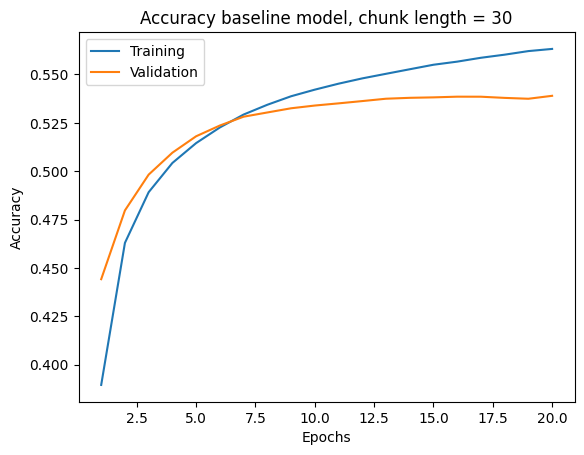

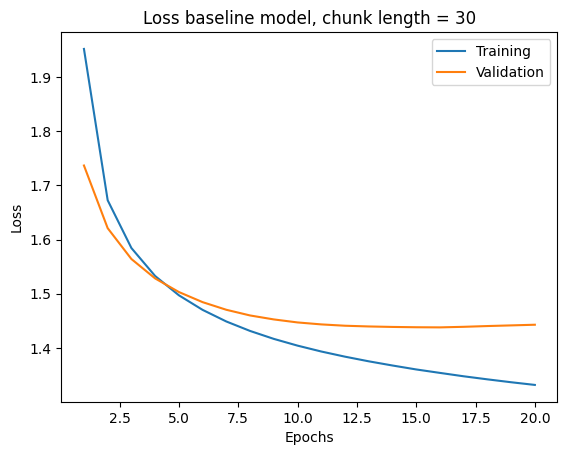

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5287 - loss: 1.4618
Test Loss: 1.4574412107467651
Test Accuracy: 0.5295677185058594


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra

--- TEXT GENERATION ---
nel mezzo del cammin di nostra miemo,

infande e di beommergisi poglia.

i fossa ond'e` del buono valle
  l'ongigni guega me videbber la fiagno.

tosto, del punto tosto la regina
  di lui e di giutera` tutto lapi,

l'accompatto del troppo cio` crudenti.

quand'i le vedei non son gordesso,
  accesia come al monte spirita esser ve


### Baseline model with chunk length = 108

In [ ]:
chunk_length = 108

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446505, 108), y_train's shape = (446505,)
X_val's shape = (55813, 108), y_val's shape = (55813,)
X_test's shape = (55814, 108), y_test's shape = (55814,)


In [ ]:
model = build_baseline_model()

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - accuracy: 0.3369 - loss: 2.1962 - val_accuracy: 0.4453 - val_loss: 1.7270
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.4551 - loss: 1.6930 - val_accuracy: 0.4787 - val_loss: 1.6186
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.4856 - loss: 1.5926 - val_accuracy: 0.4979 - val_loss: 1.5626
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.5033 - loss: 1.5350 - val_accuracy: 0.5068 - val_loss: 1.5278
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.5143 - loss: 1.4969 - val_accuracy: 0.5145 - val_loss: 1.5041
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.5226 - loss: 1.4686 - val_accuracy: 0.5169 - val_loss: 1.4900
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - accuracy: 0.5290 - loss: 1.4466 - val_accuracy: 0.5219 - val_loss: 1.4763
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 36s 10ms/step - accuracy: 0.5341 -

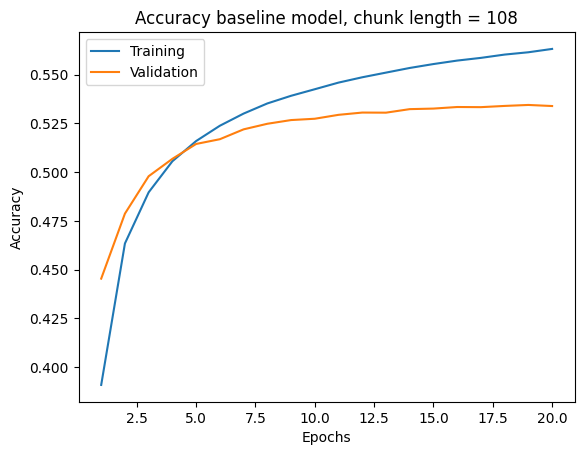

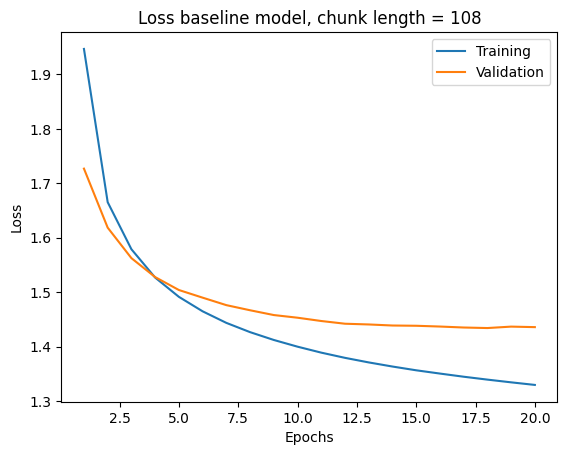

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5364 - loss: 1.4368
Test Loss: 1.4297404289245605
Test Accuracy: 0.5377683043479919


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

giusta anzi ordo e scorpesi di senno;
  ma io quando fai: <<dir che 'l velogo
  che pur avea pie` di quelli avviarro,
  fu' cittadebmi di pingra trale,

cortato pur io la virtute, marcia>>.



paradiso: canto xvi


magno subito ben consupilata,
  <<per affetta il mento dietro armibi
  ogni la schier


### Baseline model with chunk length = 150

In [ ]:
chunk_length = 150

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446472, 150), y_train's shape = (446472,)
X_val's shape = (55809, 150), y_val's shape = (55809,)
X_test's shape = (55809, 150), y_test's shape = (55809,)


In [ ]:
model = build_baseline_model()

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 50s 14ms/step - accuracy: 0.3342 - loss: 2.2131 - val_accuracy: 0.4401 - val_loss: 1.7432
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.4513 - loss: 1.7092 - val_accuracy: 0.4728 - val_loss: 1.6277
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 80s 13ms/step - accuracy: 0.4811 - loss: 1.6095 - val_accuracy: 0.4899 - val_loss: 1.5709
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.4988 - loss: 1.5536 - val_accuracy: 0.5005 - val_loss: 1.5377
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.5105 - loss: 1.5164 - val_accuracy: 0.5072 - val_loss: 1.5148
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.5184 - loss: 1.4893 - val_accuracy: 0.5130 - val_loss: 1.4987
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.5237 - loss: 1.4682 - val_accuracy: 0.5179 - val_loss: 1.4876
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 82s 13ms/step - accuracy: 0.5285 -

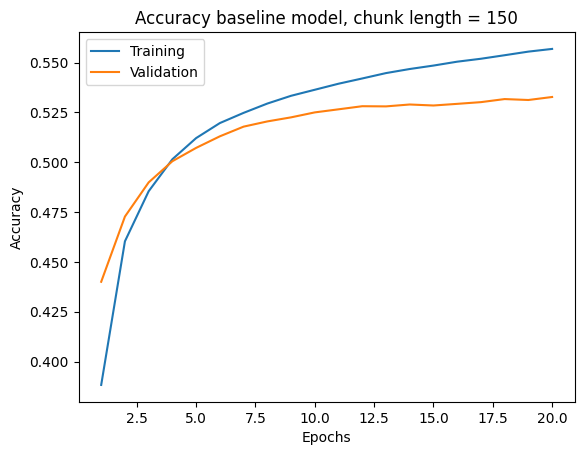

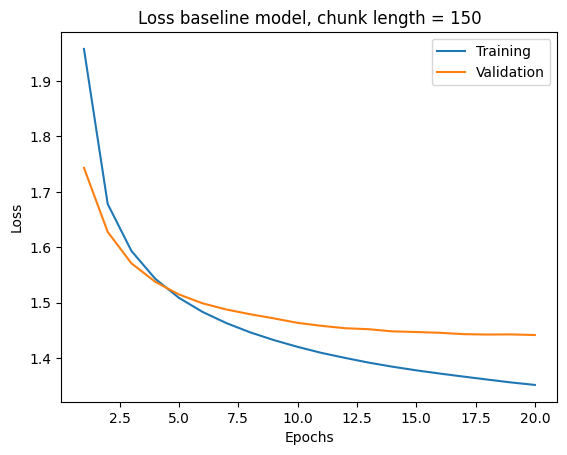

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5340 - loss: 1.4414
Test Loss: 1.4501590728759766
Test Accuracy: 0.5300041437149048


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  e

--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  e 'l tuo frommo allumate udie sivente
  e` quell'ombro` poi le' esser non e` fece
  in questa fui dal petto che l'acqua
  sonorio l'averei? <<certo ne la brigade,
  perche' duravam li luce piu` marino

questo le passi a l'orte quando, simise,
  rome che 'l vostro e ad elio effatto.

ma e albo, e poi 


### Baseline model with chunk length = 222

In [ ]:
chunk_length = 222

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446414, 222), y_train's shape = (446414,)
X_val's shape = (55802, 222), y_val's shape = (55802,)
X_test's shape = (55802, 222), y_test's shape = (55802,)


In [ ]:
model = build_baseline_model()

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 63s 18ms/step - accuracy: 0.3353 - loss: 2.2070 - val_accuracy: 0.4427 - val_loss: 1.7446
Epoch 2/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - accuracy: 0.4557 - loss: 1.7045 - val_accuracy: 0.4751 - val_loss: 1.6308
Epoch 3/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - accuracy: 0.4833 - loss: 1.6033 - val_accuracy: 0.4915 - val_loss: 1.5723
Epoch 4/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.5011 - loss: 1.5445 - val_accuracy: 0.5022 - val_loss: 1.5367
Epoch 5/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.5133 - loss: 1.5054 - val_accuracy: 0.5084 - val_loss: 1.5130
Epoch 6/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - accuracy: 0.5216 - loss: 1.4771 - val_accuracy: 0.5137 - val_loss: 1.4963
Epoch 7/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - accuracy: 0.5278 - loss: 1.4552 - val_accuracy: 0.5169 - val_loss: 1.4839
Epoch 8/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - accuracy: 0.5327 -

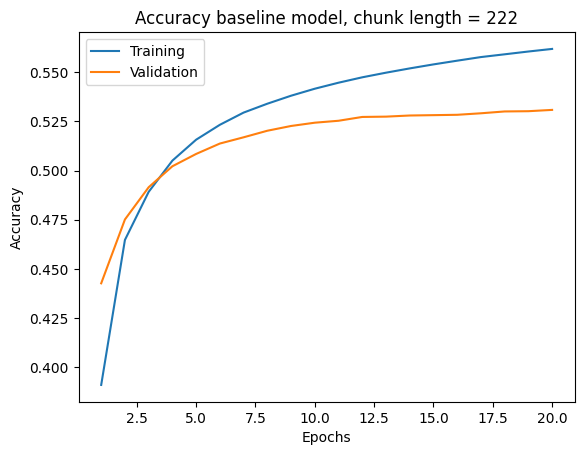

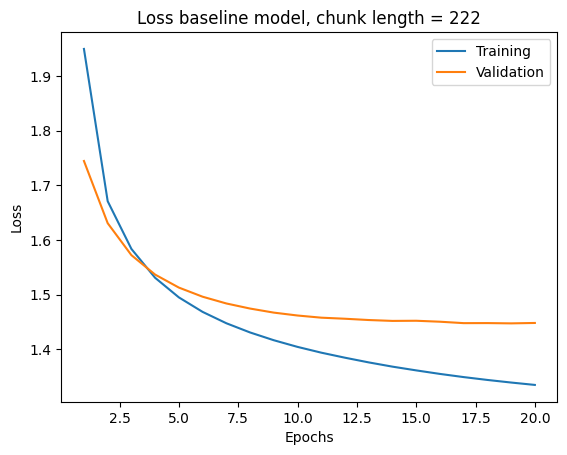

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1744/1744 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5290 - loss: 1.4439
Test Loss: 1.4417026042938232
Test Accuracy: 0.5312533378601074


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

e qui dal monte di dolce odice!

e comisceria li angeli 'ntesa,
  tal esser la virtu` che nomagio
  d'ogne mia dolorosa si` d'uno in tutti
  non, e in tuo tal perche' sono; canti,
  di del sangue la cose quinci e questa?

me quale stultima per grazia grama,
  e, e dolore e cosi` farti forti.

addio 


### Baseline model with chunk length = 300

In [ ]:
chunk_length = 300

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446352, 300), y_train's shape = (446352,)
X_val's shape = (55794, 300), y_val's shape = (55794,)
X_test's shape = (55794, 300), y_test's shape = (55794,)


In [ ]:
model = build_baseline_model()

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.3297 - loss: 2.2211 - val_accuracy: 0.4368 - val_loss: 1.7733
Epoch 2/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.4487 - loss: 1.7219 - val_accuracy: 0.4711 - val_loss: 1.6441
Epoch 3/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 83s 23ms/step - accuracy: 0.4792 - loss: 1.6195 - val_accuracy: 0.4879 - val_loss: 1.5833
Epoch 4/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step - accuracy: 0.4967 - loss: 1.5610 - val_accuracy: 0.5000 - val_loss: 1.5457
Epoch 5/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.5076 - loss: 1.5225 - val_accuracy: 0.5071 - val_loss: 1.5215
Epoch 6/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 82s 23ms/step - accuracy: 0.5157 - loss: 1.4939 - val_accuracy: 0.5125 - val_loss: 1.5036
Epoch 7/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - accuracy: 0.5217 - loss: 1.4724 - val_accuracy: 0.5149 - val_loss: 1.4934
Epoch 8/20
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 79s 23ms/step - accuracy: 0.5270 -

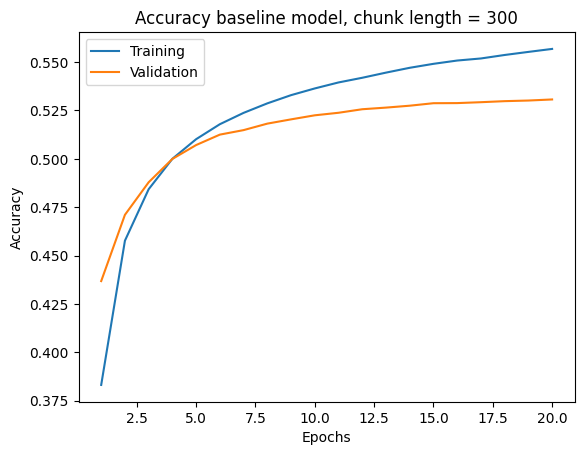

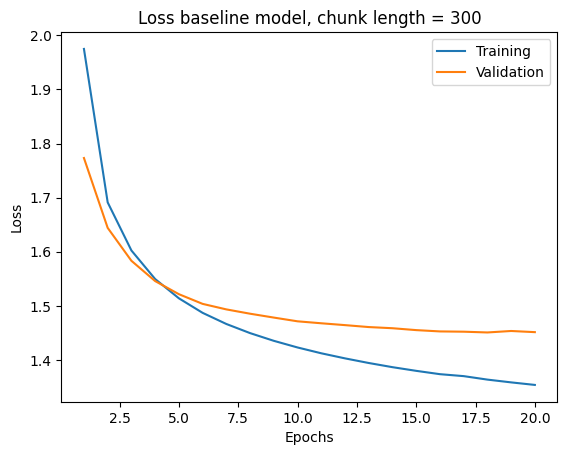

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1744/1744 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5314 - loss: 1.4415
Test Loss: 1.4410388469696045
Test Accuracy: 0.532404899597168


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length, gen_length=500)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai

--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ahi quanto a dir qual era e` cosa dura
  esta selva selvaggia e aspra e forte
  che nel pensier rinova la paura!

tant'e` amara che poco e` piu` morte;
  ma per trattar del ben ch'i' vi trovai
  qual vester, vedrada o graci prima starso.

venia vendere a lunga>>, diss'io, quella>>.

io vidi e dietro a la riprisa tosta,
  volsine e` qual ficcava luce manco.

<<ma tal noi che di volei fino concialia.

fermo mirare e io noi me ne l'uom prodini;

ch'e` con carni lor celace, io consizia;
  procorse volce, e io, ch'una risiedi
  si` come ti ditor si pa

### Choosing the "best" chunk length

To choose the best chunk length, let's evaluate some trade-offs.

- **Accuracy**
  - The accuracy across all chunk lengths is similar, with slight variations
  - Validation loss and accuracy do not show significant improvements as chunk length increases
  - Overfitting is evident across all chunk lengths and longer chunks show no notable advantage.

- **Generated text quality**
  - Shorter chunk_length (e.g., 30) produces slightly noisier, less coherent text, while intermediate values (108 and 150) generate text that aligns better with the training data
  - Beyond chunk_length=150, generated text quality doesn't improve noticeably, despite the increased computational cost.

- **Complexity**
  - Computational cost increases significantly with longer chunks, making chunk_length=300 the slowest at 80 seconds/epoch
  - Shorter lengths like 30 are computationally efficient (20 seconds/epoch), but they sacrifice some quality in generated text
  - Intermediate values like 108 and 150 provide a good balance, with reasonable epoch times and coherent text.

,Chunk length,Seconds/epoch,Train accuracy,Validation accuracy,Test accuracy,Generated text quality
0,30,20,0.5617,0.5390,0.5296,Noisy and less coherent
1,108,40,0.5634,0.5339,0.5378,Coherent and aligns well
2,150,50-80,0.5573,0.5328,0.5300,Coherent but no improvement
3,222,60-80,0.5611,0.5308,0.5313,"Similar to 150, no improvement"
4,300,80,0.5561,0.5307,0.5324,"Similar to 150 or 222, no improvement"


The chosen chunk length is **108**, because
  - it provides a **good balance** between training time, generated text quality, and model performance
  - **accuracy and loss** are **very close to longer** chunk lengths like 150 and 222, but **at a significantly lower computational cost**
  - generated text from 108 is coherent, reflecting the training data better than 30.

## Optimized models

After fixing the chunk length to the best value (108), we will focus on exploring different architectures to improve the performance.

The focus will be on:

- Adding layers, i.e. experimenting with additional LSTM layers to capture more complex patterns and dependencies in the text
- Dropout regularization, i.e. adjusting dropout rates to reduce overfitting while maintaining good generalization.

The goal is to find a balance between performance improvements (accuracy and text quality) and computational efficiency (training time).

In [ ]:
chunk_length = 108
X_train, y_train, X_val, y_val, X_test, y_test = prepare_data(chunk_length=chunk_length)

X_train's shape = (446505, 108), y_train's shape = (446505,)
X_val's shape = (55813, 108), y_val's shape = (55813,)
X_test's shape = (55814, 108), y_test's shape = (55814,)


### Model 1 - dropout 0.1

In [ ]:
model_name = "model 1"

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - accuracy: 0.3326 - loss: 2.2106 - val_accuracy: 0.4475 - val_loss: 1.7177
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 79s 12ms/step - accuracy: 0.4499 - loss: 1.7128 - val_accuracy: 0.4803 - val_loss: 1.6072
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.4782 - loss: 1.6156 - val_accuracy: 0.4983 - val_loss: 1.5506
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.4955 - loss: 1.5601 - val_accuracy: 0.5097 - val_loss: 1.5139
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.5054 - loss: 1.5254 - val_accuracy: 0.5153 - val_loss: 1.4923
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 42s 12ms/step - accuracy: 0.5142 - loss: 1.4988 - val_accuracy: 0.5217 - val_loss: 1.4759
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 80s 11ms/step - accuracy: 0.5193 - loss: 1.4789 - val_accuracy: 0.5247 - val_loss: 1.4668
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.5246 -

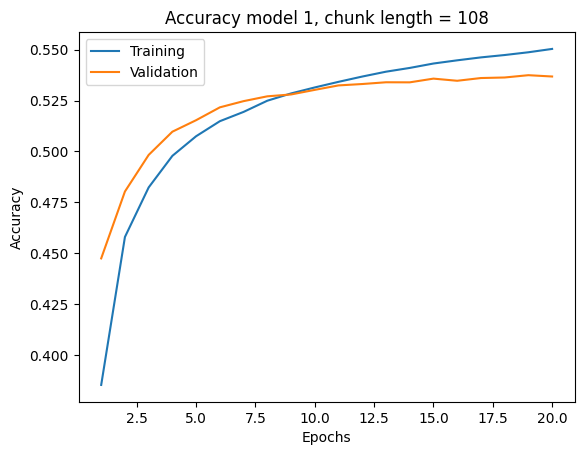

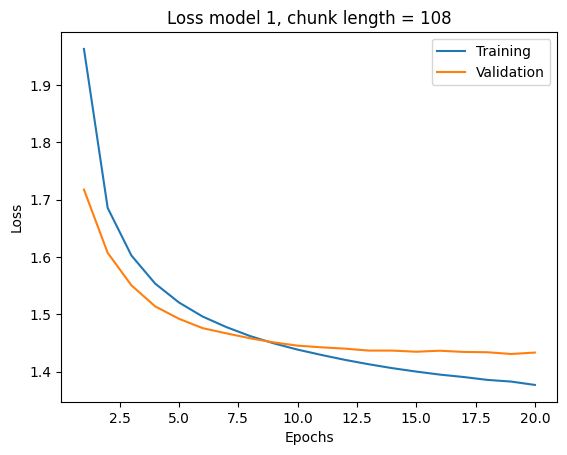

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5326 - loss: 1.4453
Test Loss: 1.4325882196426392
Test Accuracy: 0.5373920798301697


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

memo di semendar su` pur savra,
  e due crida cosi` poi m'apverde,
  ond'ancor matto pecaper di serpi lo,
  ficinurbimo in dietro e alcuni agra.

vidi ul doppol detto che d'usci pola>>,
  rispuosi: <<questo ben avander s'apparia,
  si vicino: <<quel che 'l color ch'io un giro
  tiregno e, e la spede


### Model 2 - dropout 0.3

In [ ]:
model_name = "model 2"

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.3218 - loss: 2.2482 - val_accuracy: 0.4477 - val_loss: 1.7258
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.4402 - loss: 1.7524 - val_accuracy: 0.4791 - val_loss: 1.6145
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.4669 - loss: 1.6599 - val_accuracy: 0.4963 - val_loss: 1.5587
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.4819 - loss: 1.6085 - val_accuracy: 0.5048 - val_loss: 1.5261
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.4928 - loss: 1.5751 - val_accuracy: 0.5113 - val_loss: 1.5049
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.5000 - loss: 1.5503 - val_accuracy: 0.5144 - val_loss: 1.4951
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.5058 - loss: 1.5294 - val_accuracy: 0.5197 - val_loss: 1.4739
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - accuracy: 0.5098 -

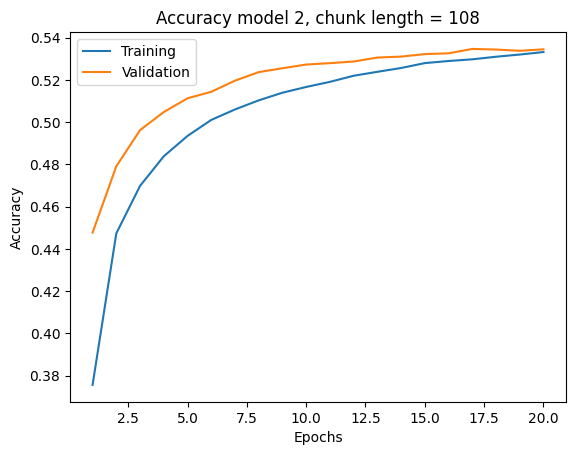

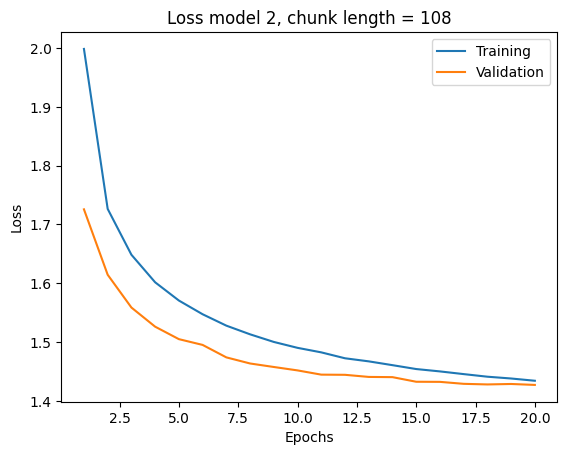

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.5317 - loss: 1.4371
Test Loss: 1.4273288249969482
Test Accuracy: 0.5351703763008118


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

padre, e vedera, la ventane viva
  di verressi assifalia e maran cinte,
  gente mia gia` che poi che t'arsisi.

miglio, e sette: con vuoi calestri,
  si` con lei piu` salvare ond'e` un frave
  insegni cerpetron ch'esce, e 'l vato:

e campersar sappia moravana.

anzavaprio, e quell'a giusso da porta;


### Model 3 - one more layer & one dropout 0.3

In [ ]:
model_name = "model 3"

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
model.add(LSTM(units=256, return_sequences=True))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 102s 27ms/step - accuracy: 0.3225 - loss: 2.2435 - val_accuracy: 0.4667 - val_loss: 1.6568
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 138s 27ms/step - accuracy: 0.4676 - loss: 1.6584 - val_accuracy: 0.5067 - val_loss: 1.5281
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.5050 - loss: 1.5351 - val_accuracy: 0.5258 - val_loss: 1.4656
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 96s 27ms/step - accuracy: 0.5247 - loss: 1.4690 - val_accuracy: 0.5353 - val_loss: 1.4316
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.5364 - loss: 1.4223 - val_accuracy: 0.5416 - val_loss: 1.4108
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 141s 27ms/step - accuracy: 0.5467 - loss: 1.3874 - val_accuracy: 0.5433 - val_loss: 1.4022
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.5541 - loss: 1.3591 - val_accuracy: 0.5472 - val_loss: 1.3942
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0

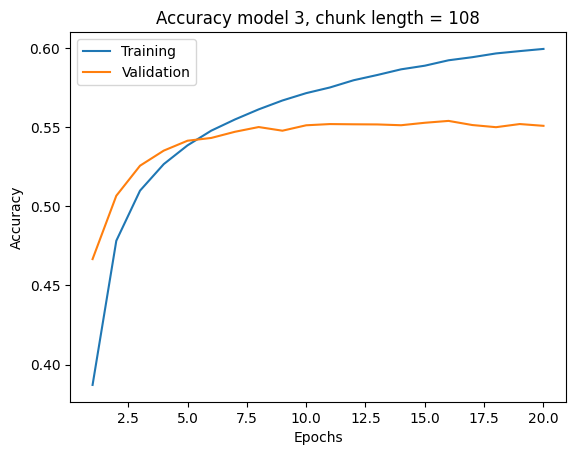

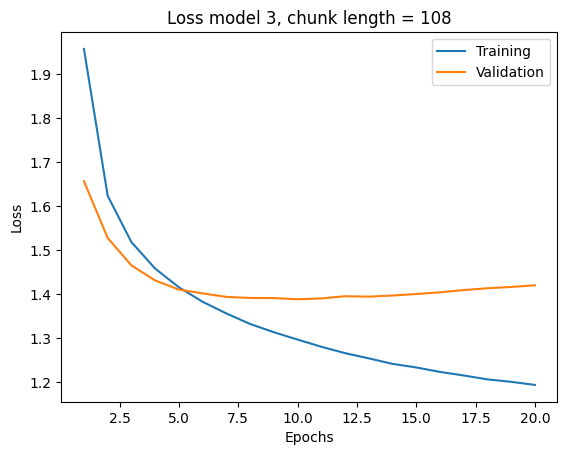

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5492 - loss: 1.4197
Test Loss: 1.4100663661956787
Test Accuracy: 0.5540903806686401


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

ella dentro la circunceran le pace>>.

e io: <<onde succendo di lei avi

onde i' si fan tornar le bace in logge
  lo duca: 'i' s'e` cisner voi di qua ti puote
  mi congense di retro mi rispondo.

poscia vi coccio` per prima e verna,
  per corti siete e` costui verso l'arto;
  non fora la padre e col


### Model 4 - one more layer & two dropouts 0.3

In [ ]:
model_name = "model 4"

In [ ]:
# Define the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size))
model.add(LSTM(units=256, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(vocab_size, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 102s 28ms/step - accuracy: 0.3153 - loss: 2.2728 - val_accuracy: 0.4579 - val_loss: 1.6824
Epoch 2/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.4501 - loss: 1.7139 - val_accuracy: 0.4930 - val_loss: 1.5557
Epoch 3/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - accuracy: 0.4819 - loss: 1.6074 - val_accuracy: 0.5132 - val_loss: 1.4935
Epoch 4/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 28ms/step - accuracy: 0.5002 - loss: 1.5467 - val_accuracy: 0.5242 - val_loss: 1.4552
Epoch 5/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 143s 29ms/step - accuracy: 0.5116 - loss: 1.5070 - val_accuracy: 0.5333 - val_loss: 1.4326
Epoch 6/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 142s 29ms/step - accuracy: 0.5196 - loss: 1.4819 - val_accuracy: 0.5381 - val_loss: 1.4155
Epoch 7/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.5259 - loss: 1.4588 - val_accuracy: 0.5428 - val_loss: 1.4034
Epoch 8/20
3489/3489 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.5

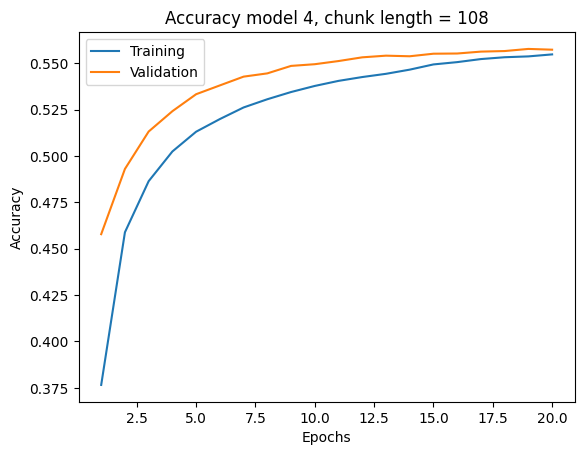

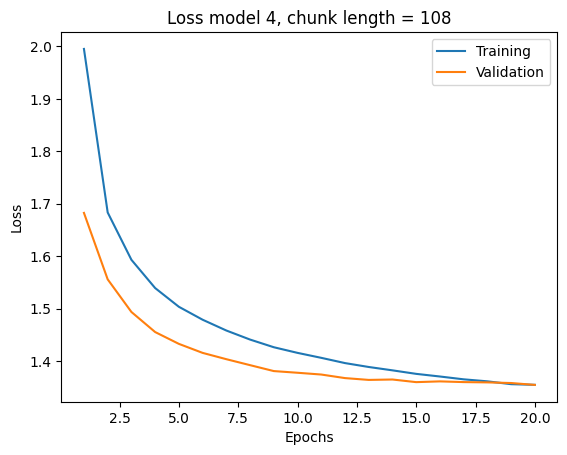

In [ ]:
# Plot learning curves
plot_accuracy(history, f"Accuracy {model_name}, chunk length = {chunk_length}")
plot_loss(history, f"Loss {model_name}, chunk length = {chunk_length}")

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

1745/1745 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.5533 - loss: 1.3628
Test Loss: 1.350766897201538
Test Accuracy: 0.5582112073898315


In [ ]:
# Generate some text
generated = generate_text(model=model, chunk_length=chunk_length)
print("\n--- TEXT GENERATION ---")
print(generated)

start_string:
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.



--- TEXT GENERATION ---
nel mezzo del cammin di nostra vita
  mi ritrovai per una selva oscura
  che' la diritta via era smarrita.

guarda si` voler fia che sciocca voni
  ch'i' ho dugno, a che si pareva 'l suo coro
  piu` oppressa al mondo a duol, come face;

e che' mi vuol che 'l farti quella conda,

la donna cornita` cosi` prove.

n'anci poi che son in vergo legno
  tutt'i volger che nei, mi rimasi.

li occhi nascer con le pa


### Choosing the best model and conclusions

After fixing the chunk length to 108 (from previous tuning), different architectures were explored to improve performance.

The focus was on adding layers, modifying dropout rates, and balancing computational complexity with accuracy and text generation quality.

- **Accuracy**
  - Model 4 achieves the highest accuracy across validation (0.5573) and test (0.5582)
  - Model 2, while slightly lower in accuracy (test accuracy = 0.5352), offers a balanced trade-off in terms of time and performance.

- **Generated text quality**
  - Model 1 produces reasonable text but lacks refinement compared to deeper architectures
  - Model 4 generates the most coherent and contextually aligned text.

- **Complexity**
  - Models 3 and 4 are significantly slower (~140 seconds/epoch) compared to Models 1 and 2 (~40 seconds/epoch).
  - Increasing layers and adding dropouts lead to decreasing returns in accuracy relative to computational cost.

,Model,Seconds/epoch,Train accuracy,Validation accuracy,Test accuracy,Generated text quality
0,Model 1 (Dropout 0.1),40,0.5509,0.5368,0.5374,Coherent but less refined
1,Model 2 (Dropout 0.3),40,0.5339,0.5345,0.5352,Slightly less coherent but reasonable
2,"Model 3 (1 extra LSTM, 1 Dropout 0.3)",140,0.6006,0.5510,0.5541,Coherent with better variety
3,"Model 4 (1 extra LSTM, 2 Dropouts 0.3)",140,0.5553,0.5573,0.5582,"Most coherent and diverse, aligns well"


If training time is not a concern, **Model 4** is the best choice due to its superior accuracy and text generation quality.

For scenarios **with limited training time**, **Model 2** provides a good balance, with lower complexity and competitive performance.

While more complex LSTM architectures (e.g., additional layers or units) could marginally improve accuracy, the increase in training time becomes impractical.

For a significant improvement, exploring more advanced models is recommended, in particular those models which are better suited for capturing long-term dependencies in text.


In conclusion, we demonstrated the ability to train and evaluate LSTM-based models for next character prediction in the Divina Commedia.

The best chunk length was determined to be 108, providing an efficient trade-off among accuracy, text quality, and complexity (training time).

After optimizing the architecture, we concluded:

- **Model 4** is ideal for accuracy and text coherence, but at a higher computational cost
- **Model 2** is the best choice for balanced performance and efficiency.

For future work on this task, we should focus on adopting more sophisticated architectures to address the limitations of LSTMs.

Furthermore, we expect the trained models to perform similarly or worse on **external text**, as the LSTM architecture struggles to fully capture the intricate patterns of the training set.

This is particularly relevant given that the Divina Commedia is a very specific poem, written in fiorentino by Dante using terzine, which presents unique linguistic and structural challenges.